# Первая часть проекта (работа с табличными данными)

## **Описание задачи**

Предсказание цены коммерческой недвижимости. Оценка вручную занимает много времени (долгая оценка = задержка решения по выдаче кредита → можно потерять клиента), зато есть много данных по оценке стоимости недвижимости из объявлений в интернете. Предлагается сравнить эти 2 группы наблюдений.

* [Описание данных](https://russianhackers.notion.site/c666cd6d3d8c44adb79d73f69d3ee81a?v=2b1e857b3252422a87cd95cf51225ba0)
* [Описание исходной задачи](https://russianhackers.notion.site/6b142361271a42feb6581759a8c886e0)

# 1. Поиск причинно-следственных связей

# EDA 

**(Вам нужно рассмотреть ваши данные и предположить, как могут быть связаны признаки в ваших данных.)**

In [51]:
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
import lightgbm as lgb
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RepeatedKFold, cross_val_score

import optuna
from optuna.samplers import TPESampler
from optuna.study import Study

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

In [ ]:
train = pd.read_csv("../data/train_processed.csv")
# train = train[train["price_type"] == 1]
train.head()

In [ ]:
target = "per_square_meter_price"
drop_cols = [target, "id", "price_type", 'date']
cols = [col for col in train.columns if col not in drop_cols]
cat_cols = ["city", "osm_city_nearest_name", "region", "street", 'city_type']

In [ ]:
for col in cat_cols:
    train[col] = train[col].astype("category")

In [ ]:
train[target] = np.log(train[target])

In [ ]:
folds_optuna = RepeatedKFold(n_splits=5, n_repeats=1, random_state=0)

def objective(trial):
    param = {
        "verbosity": -1,
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "n_estimators": trial.suggest_int("n_estimators", 20, 1500),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "subsample": trial.suggest_float("subsample", 0.4, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-8, 10.0, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 25),
    }
    
    model = lgb.LGBMRegressor(**param)
    score = cross_val_score(model, train[cols], train[target], cv=folds_optuna, scoring="neg_mean_squared_error")
    return score.mean()

In [ ]:
sampler = TPESampler(seed=0)
direction = "maximize"
study = optuna.create_study(sampler=sampler, direction=direction)

study.optimize(
    objective,
    show_progress_bar=True,
    n_trials=100,
)

In [44]:
study.best_params

{'reg_alpha': 6.509148825494632e-08,
 'reg_lambda': 1.823229475907686e-08,
 'num_leaves': 162,
 'n_estimators': 1370,
 'colsample_bytree': 0.8507214842610268,
 'subsample': 0.5068912539055478,
 'subsample_freq': 1,
 'min_child_samples': 18,
 'learning_rate': 0.006533652298850138,
 'max_depth': 15}

In [ ]:
study.trials_dataframe().sort_values("value", ascending=False).head(15)

In [45]:
study.trials[45].params

{'reg_alpha': 3.842394964647047e-06,
 'reg_lambda': 1.3457165400059045e-07,
 'num_leaves': 185,
 'n_estimators': 329,
 'colsample_bytree': 0.7609454453893679,
 'subsample': 0.4007257897002692,
 'subsample_freq': 6,
 'min_child_samples': 8,
 'learning_rate': 0.01375836425783044,
 'max_depth': 18}

In [ ]:
N_SPLITS = 5
N_REPEATS = 3

folds = RepeatedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=0)

In [ ]:
params = {'reg_alpha': 3.842394964647047e-06,
 'reg_lambda': 1.3457165400059045e-07,
 'num_leaves': 185,
 'n_estimators': 329,
 'colsample_bytree': 0.7609454453893679,
 'subsample': 0.4007257897002692,
 'subsample_freq': 6,
 'min_child_samples': 8,
 'learning_rate': 0.01375836425783044,
 'max_depth': 18}

model = lgb.LGBMRegressor(**params)

In [46]:
score = cross_val_score(model, train[cols], train[target], cv=folds, scoring="neg_mean_squared_error")
print(f"Score: {score.mean():.4f}")

Score: -0.1027


In [ ]:
n_total = N_SPLITS * N_REPEATS
importances = np.zeros((n_total, len(cols)))

for i, (train_idx, val_idx) in tqdm(enumerate(folds.split(train)), total=n_total):
    X_train, X_val = train[cols].iloc[train_idx], train[cols].iloc[val_idx]
    y_train, y_val = train[target].iloc[train_idx], train[target].iloc[val_idx]
    
    model.fit(X_train, y_train)

    result = permutation_importance(
        model, 
        X_val, 
        y_val, 
        scoring="neg_mean_squared_error",
        n_repeats=1,
        random_state=42
    )
    importances[i] = result.importances_mean

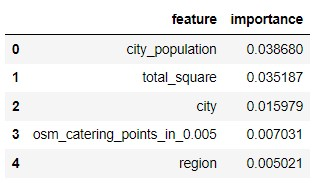

In [47]:
imp = pd.DataFrame(importances, columns=cols).T.mean(axis=1).sort_values(ascending=False).reset_index()
imp.columns = ["feature", "importance"]
imp.head()

In [48]:
(imp["importance"] > 1e-3).sum()

21


In [ ]:
imp_cols = imp.loc[imp["importance"] > 1e-3, "feature"].tolist()

In [49]:
imp_cols = [
    'city_population',
    'total_square',
    'osm_catering_points_in_0.005',
    'region',
    'floor',
    'realty_type',
    'osm_crossing_closest_dist',
    'osm_city_nearest_name',
    'osm_subway_closest_dist',
    'reform_mean_floor_count_1000',
    'osm_transport_stop_closest_dist',
    'osm_amenity_points_in_0.001',
    'osm_city_nearest_population',
    'lng',
    'osm_city_closest_dist',
    'osm_crossing_points_in_0.005',
    'floor_type',
    'lat',
    'reform_mean_year_building_500',
    'osm_culture_points_in_0.005',
    'reform_house_population_500',
]
len(imp_cols)

21


In [50]:
score = cross_val_score(model, train[imp_cols], train[target], cv=folds, scoring="neg_mean_squared_error")
print(f"Score: {score.mean():.4f}")

Score: -0.1022


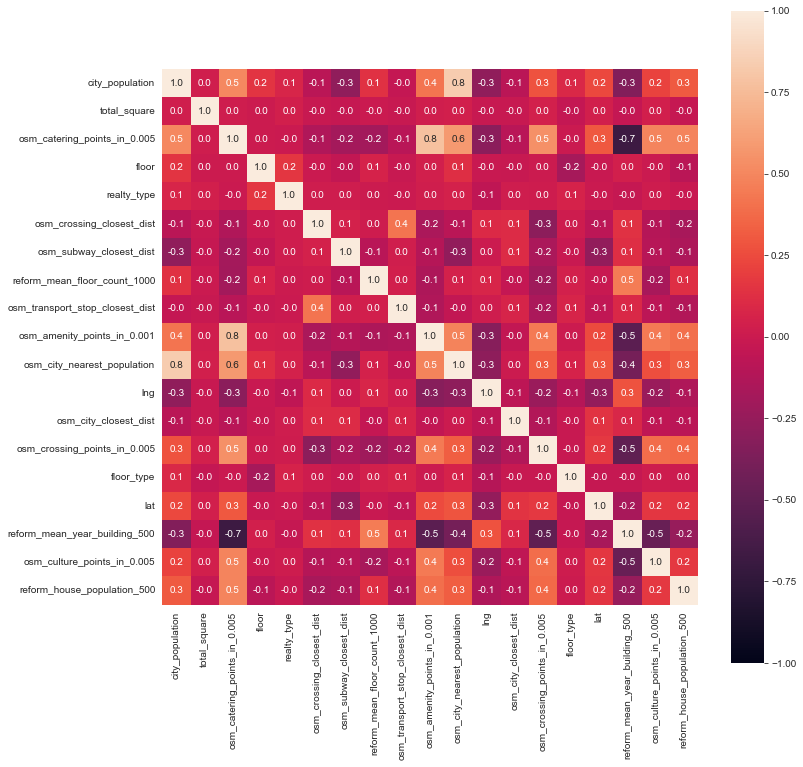

In [53]:
plt.figure(figsize=(12, 12))
sns.heatmap(train[imp_cols].corr(), vmin=-1, vmax=1, square=True, annot=True, fmt=".1f")

### Гипотеза:

 Если дома в радиусе 500 метров в среднем построены позже 1991 (после распад СССР), то это положительно влияет на цену за квадратный метр

In [41]:
import dowhy
from dowhy import CausalModel

from sklearn.preprocessing import LabelEncoder

import networkx as nx
from IPython.display import Image

import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [3]:
dataset = pd.read_csv("../data/train_simple.gzip", compression="gzip")
dataset.shape

In [4]:
cat_cols = ["region", "osm_city_nearest_name", "realty_type"]

for col in cat_cols:
    le = LabelEncoder()
    dataset[col] = le.fit_transform(dataset[col])

In [5]:
dataset["floor"] = dataset["floor"].fillna(1)
dataset["city_population"] = dataset["city_population"].fillna(0)

In [6]:
dataset["price_type"] = dataset["price_type"].astype(bool)

In [7]:
dataset.isna().sum().sum()

0

#### Получение бинарного признака из reform_mean_year_building_500

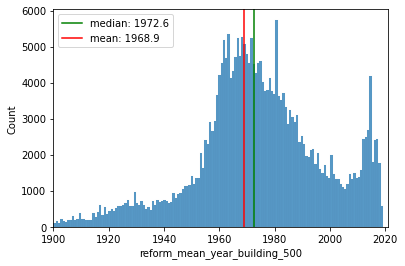

In [20]:
mean = dataset["reform_mean_year_building_500"].mean()
median = dataset["reform_mean_year_building_500"].median()
sns.histplot(dataset["reform_mean_year_building_500"])
plt.axvline(median, label=f"median: {median:.1f}", c='g')
plt.axvline(mean, label=f"mean: {mean:.1f}", c='r')
plt.xlim([1900, 2021])
plt.legend()
plt.show()

In [21]:
dataset["reform_mean_year_building_500_after_1991"] = dataset["reform_mean_year_building_500"].apply(lambda x: True if x > 1991 else False)
del dataset["reform_mean_year_building_500"]

dataset["reform_mean_year_building_500_after_1991"].value_counts()

False    220203
True      59589
Name: reform_mean_year_building_500_after_1991, dtype: int64

## 1.1. Causal graph  на основе собственных предположений

In [115]:
target = "per_square_meter_price"
treatment = "reform_mean_year_building_500_after_1991" # Дома в радиусе 500 метров в среднем построены позже 1991 (распад СССР)

In [116]:
feature_columns = [
    'city_population',                  # Население города
    'total_square',                     # Общая площадь
    'osm_catering_points_in_0.005',     # Кол-во заведений общепита в радиусе 500 метров, OpenStreetMap
    'region',                           # Регион
    'floor',                            # Этаж
    'realty_type',                      # Тип недвижимости (закодирован)
    'osm_crossing_closest_dist',        # Расстояние до ближайшего пешеходного перехода
    'osm_subway_closest_dist',          # Расстояние до ближайщей станции метро, OpenStreetMap
    'reform_mean_floor_count_1000',     # Средняя этажность домов в радиусе 1 км по истоинчку РеформаЖКХ
    'osm_transport_stop_closest_dist',  # Расстояние до ближайщей остановки общественного транспорта, OpenStreetMap
    'osm_amenity_points_in_0.001',      # Кол-во объектов связанных с удобством в радиусе 100 метров, OpenStreetMap
    'osm_city_closest_dist',            # Расстояние до центра ближайшего города, OpenStreetMap
    'floor_type',                       # Тип этажа
]

### Зависимости:

- Население города влияет на то, в какой период времени в среднем дома в радиусе 500 метров построены. Чем больше население, тем больше новостроя
- Регион влияет на население города.
- Общая площадь говорит о том, в какой период построены дома вокруг. Возможно в новостое площадь помещений меньше.
- Тип недвижимости может влиять на количество этажей в сооружении
- Кол-во заведений общепита в округе повышает кол-во объектов связанных с удобством

In [117]:
graph = nx.DiGraph()
graph.add_nodes_from([treatment, target])
graph.add_nodes_from(feature_columns[:-1])
graph.add_node(target, color='red')
graph.add_nodes_from([(target, {"color": "red"})])
graph.add_edges_from([
    ('city_population', 'osm_catering_points_in_0.005'),
    ('city_population', 'osm_subway_closest_dist'),
    ('city_population', 'osm_amenity_points_in_0.001'),
    ('city_population', 'reform_mean_year_building_500_after_1991'),
    ('total_square', 'reform_mean_year_building_500_after_1991'),
    ('osm_catering_points_in_0.005', 'osm_amenity_points_in_0.001'),
    ('osm_catering_points_in_0.005', 'reform_mean_year_building_500_after_1991'),
    ('region', 'city_population'),
    ('region', 'reform_mean_year_building_500_after_1991'),
    ('realty_type', 'floor'),
    ('floor_type', 'floor'),
])

graph.add_edges_from([(col, target) for col in feature_columns])
graph.add_edge(treatment, target)

In [118]:
color_map = []
for i in range(len(graph.nodes)):
    if i < 2:
        color_map.append('red')
    else:
        color_map.append('blue')

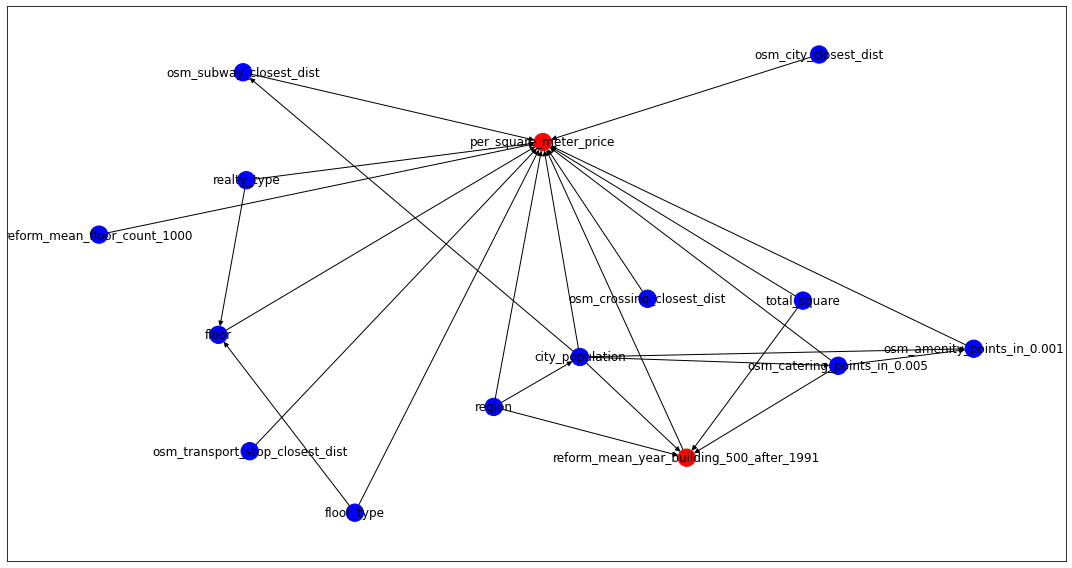

In [129]:
plt.figure(figsize=(15, 8))
nx.draw_networkx(graph, pos=nx.spring_layout(graph), node_color=color_map)
plt.tight_layout()

In [132]:
dataset = dataset.loc[:, feature_columns + [treatment] + [target]]

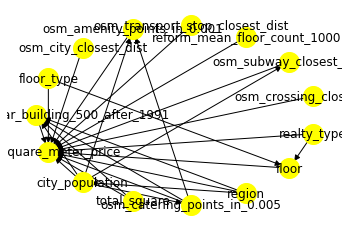

In [133]:
model = CausalModel(
    data=dataset,
    treatment=treatment,
    outcome=target,
    graph=" ".join(nx.generate_gml(graph))
)

model.view_model()

## 1.2. Refutation methods

### Step 2. Identification (formulating what to estimate)

In [134]:
%%time

identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
                     d                                                        
───────────────────────────────────────────(Expectation(per_square_meter_price
d[reform_mean_year_building_500_after_1991]                                   

                                                                              
|osm_catering_points_in_0.005,osm_amenity_points_in_0.001,region,osm_city_clos
                                                                              

                                                                              
est_dist,realty_type,city_population,osm_transport_stop_closest_dist,floor,osm
                                                                              

                                                                              
_crossing_closest_dist,floor_type,total_square,osm_subway_closest_dist,reform_
                                

### Step 3. Estimation (compute the estimate)

In [149]:
%%time

estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_stratification",
    target_units="ate",
)

print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
                     d                                                        
───────────────────────────────────────────(Expectation(per_square_meter_price
d[reform_mean_year_building_500_after_1991]                                   

                                                                              
|osm_catering_points_in_0.005,osm_amenity_points_in_0.001,region,osm_city_clos
                                                                              

                                                                              
est_dist,realty_type,city_population,osm_transport_stop_closest_dist,floor,osm
                                                                              

                                                                              
_crossing_closest_dist,floor_type,total_square,osm_subway_close

#### Вывод: Если дома в радиусе 500 метров в среднем построены позже 1991, то это отрицательно влияет на стоимость квадратного метра (цена уменьшается)

### Step 4. Refutation

### Refute 1

**Добавим случайную общую причину для reform_mean_year_building_500_after_1991 и per_square_meter_price, чтобы оценить ее влияние на полученную оценку**

In [64]:
%%time

refute_results = model.refute_estimate(
    identified_estimand, 
    estimate,
    method_name="random_common_cause",
    random_seed=0
)
print(refute_results)

Refute: Add a Random Common Cause
Estimated effect:-28854.788995822175
New effect:-28853.952628461047

Wall time: 1.37 s


**Оценка не изменилась, значит мы правильно оценили эффекты влияния treatment на target и общей причины нет**

### Refute 2

**Заменим treatment независимой случайной величиной, чтобы проверить, является ли полученная нами изначальная оценка случайной**

In [65]:
%%time

res_placebo = model.refute_estimate(
    identified_estimand, 
    estimate,
    method_name="placebo_treatment_refuter", 
    placebo_type="permute", 
    num_simulations=5,
)
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:-28854.788995822175
New effect:-21.923162880899145
p value:0.4895260587196145

Wall time: 8.34 s


**Причинно-следственный эффект оказался незначительным с первоначальным, значит наша оценка влияния treatment на target состоятельна**

### Refute 3

**Заменим таргет независимой случайной величиной. Если наша первоначальная оценка причинно-следственного эффекта неверна, то мы получим значительный эффект**

In [66]:
res_dummy = model.refute_estimate(
    identified_estimand, 
    estimate,
    method_name="dummy_outcome_refuter", 
    placebo_type="permute", 
    num_simulations=5,
)
print(res_dummy[0])

Refute: Use a Dummy Outcome
Estimated effect:0
New effect:0.0009405882072132277
p value:0.4276298511623757

Wall time: 7.22 s


**Полученный причинно-следственный эффект оказался близок к нулю, значит наша оценка влияния treatment на target состоятельна**

### Refute 4

**Заменим набор данных случайным выбранным подмножеством и проверим изменится оценочный эффект**

In [158]:
%%time

res_subset = model.refute_estimate(
    identified_estimand, 
    estimate,
    method_name="data_subset_refuter", 
    subset_fraction=0.9, 
    num_simulations=5,
    random_state=0,
)
print(res_subset)

Refute: Use a subset of data
Estimated effect:-28854.788995822175
New effect:-31326.353135055873
p value:0.0

Wall time: 8.55 s


C:\Users\Sasha\AppData\Roaming\Python\Python38\site-packages\dowhy\causal_refuter.py:201: RuntimeWarning: divide by zero encountered in double_scalars
  z_score = (estimate.value - mean_refute_values)/ std_dev_refute_values


**Эффект изменился в разумных пределах, значит наша оценка влияния treatment на target состоятельна**

## 1.3. Default Causal Graph

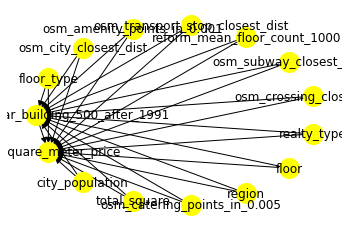

In [54]:
model = CausalModel(
    data=dataset,
    treatment=treatment,
    outcome=target,
    common_causes=feature_columns,
)

model.view_model()

### Refutation methods

### Step 2. Identification (formulating what to estimate)

In [56]:
%%time

identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
                     d                                                        
───────────────────────────────────────────(Expectation(per_square_meter_price
d[reform_mean_year_building_500_after_1991]                                   

                                                                              
|osm_transport_stop_closest_dist,floor_type,osm_catering_points_in_0.005,regio
                                                                              

                                                                              
n,realty_type,osm_amenity_points_in_0.001,total_square,floor,osm_crossing_clos
                                                                              

                                                                              
est_dist,reform_mean_floor_count_1000,osm_city_closest_dist,city_population,os
                                

### Step 3. Estimation (compute the estimate)

In [59]:
%%time

estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_stratification",
    target_units="ate",
)

print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
                     d                                                        
───────────────────────────────────────────(Expectation(per_square_meter_price
d[reform_mean_year_building_500_after_1991]                                   

                                                                              
|osm_transport_stop_closest_dist,floor_type,osm_catering_points_in_0.005,regio
                                                                              

                                                                              
n,realty_type,osm_amenity_points_in_0.001,total_square,floor,osm_crossing_clos
                                                                              

                                                                              
est_dist,reform_mean_floor_count_1000,osm_city_closest_dist,cit

#### Вывод: Получен тот же результат, что и с кастомным графом

### Step 4. Refutation

### Refute 1

**Добавим случайную общую причину для reform_mean_year_building_500_after_1991 и per_square_meter_price, чтобы оценить ее влияние на полученную оценку**

In [67]:
%%time

refute_results = model.refute_estimate(
    identified_estimand, 
    estimate,
    method_name="random_common_cause",
    random_seed=0
)
print(refute_results)

Refute: Add a Random Common Cause
Estimated effect:-28854.788995822175
New effect:-28853.952628461047

Wall time: 1.34 s


**Оценка не изменилась, значит мы правильно оценили эффекты влияния treatment на target и общей причины нет**

### Refute 2

**Заменим treatment независимой случайной величиной, чтобы проверить, является ли полученная нами изначальная оценка случайной**

In [68]:
%%time

res_placebo = model.refute_estimate(
    identified_estimand, 
    estimate,
    method_name="placebo_treatment_refuter", 
    placebo_type="permute", 
    num_simulations=5,
)
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:-28854.788995822175
New effect:-308.6820211227558
p value:0.1583422686601248

Wall time: 7.56 s


**Причинно-следственный эффект оказался незначительным, по сравнению с первоначальным, значит наша оценка влияния treatment на target состоятельна**

### Refute 3

**Заменим таргет независимой случайной величиной. Если наша первоначальная оценка причинно-следственного эффекта неверна, то мы получим значительный эффект**

In [69]:
%%time

res_dummy = model.refute_estimate(
    identified_estimand, 
    estimate,
    method_name="dummy_outcome_refuter", 
    placebo_type="permute", 
    num_simulations=5,
)
print(res_dummy[0])

Refute: Use a Dummy Outcome
Estimated effect:0
New effect:-0.001197504780635029
p value:0.42357279635179457

Wall time: 7.31 s


**Полученный причинно-следственный эффект оказался близок к нулю, значит наша оценка влияния treatment на target состоятельна**

### Refute 4

**Заменим набор данных случайным выбранным подмножеством и проверим изменится оценочный эффект**

In [70]:
%%time

res_subset = model.refute_estimate(
    identified_estimand, 
    estimate,
    method_name="data_subset_refuter", 
    subset_fraction=0.9, 
    num_simulations=5,
    random_state=0,
)
print(res_subset)

Refute: Use a subset of data
Estimated effect:-28854.788995822175
New effect:-31326.353135055873
p value:0.0

Wall time: 8.04 s


**Эффект изменился в разумных пределах, значит наша оценка влияния treatment на target состоятельна**

### Вывод: результаты не изменились при сравнении с кастомным графом